In [14]:
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import os
import json
import pandas as pd
import plotly.graph_objects as go

# Données

In [2]:
data_dir = 'data'
data = json.load(open(os.path.join(data_dir, 'large_instance.json')))

 # Modèle

In [3]:
m = Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-28


# Utils

In [4]:
# quelques données utiles
n_staff = len(data['staff'])
n_jobs = len(data['jobs'])
horizon = data['horizon']
n_qualifications = len(data['qualifications'])

#relier les qualification (A, B, C, ...) à leur index dans les matrices de variables
qualification_to_idx = {value: idx for idx, value in enumerate(data['qualifications'])}

#données binaire pour savoir si un collaborateur a une qualification
has_qualification = np.zeros((n_staff, n_qualifications), dtype=np.int)
for staff_idx in range(n_staff):
    for qualification in data['qualifications']:
        has_qualification[staff_idx, qualification_to_idx[qualification]] = qualification in data['staff'][staff_idx]['qualifications']

<ipython-input-4-505af2d5906c>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  has_qualification = np.zeros((n_staff, n_qualifications), dtype=np.int)


# Variables

In [5]:
### variables de décision ###

#vecteur binaire pour savoir si un projet est réalisé
job_is_done = m.addMVar(
    (n_jobs), vtype=GRB.BINARY
)

#matrice binaire pour savoir si un collaborateur c travail sur le projet p le jour j sur le qualification s
work = m.addMVar(
    (n_staff, 
     n_jobs, 
     horizon, 
     n_qualifications), vtype=GRB.BINARY
)

#matrice binaire pour savoir à quels projets à participé chaque colaborateur
participate = m.addMVar(
    (n_staff,
     n_jobs), vtype=GRB.BINARY
)

#matrice binaire pour savoir quels projets sont en cours quels jours
job_is_active = m.addMVar(
    (n_jobs,
     horizon), vtype=GRB.BINARY
)

### variables de modélisation ###

#vecteur pour connaître la date de réalisation de début de projet
start_date = m.addMVar(
    (n_jobs), vtype=GRB.INTEGER
)

#vecteur pour connaître la date de réalisation de chaque projet
finish_date = m.addMVar(
    (n_jobs), vtype=GRB.INTEGER
)

#vecteur binaire pour savoir si un job est temriné en retard
job_has_delay = m.addMVar(
    (n_jobs), vtype=GRB.BINARY
)

#vecteur des pénalités par projet
job_penalty = m.addMVar(
    (n_jobs), vtype=GRB.INTEGER
)

#vecteur des profits par propet
job_profit = m.addMVar(
    (n_jobs), vtype=GRB.INTEGER
)

#variable qui représente le nombre de jobs de l'employé qui en a le plus
max_job_per_staff = m.addVar(vtype=GRB.INTEGER)

#variable qui représente le nombre de jour que prend le projet le plus long
max_len_job = m.addVar(vtype=GRB.INTEGER)

m.update()

# Contraintes

In [6]:
M = 100
epsilon = 0.01

In [7]:
# Contrainte de couverture des tâches d'un projet
for job_idx, job in enumerate(data['jobs']):
    for qualification, quantity in job['working_days_per_qualification'].items():
        if qualification in job['working_days_per_qualification'].keys():
            m.addConstr(work[:, job_idx, :, qualification_to_idx[qualification]].sum() <= job['working_days_per_qualification'][qualification])
        else:
            m.addConstr(work[:,job_idx,:,qualification_to_idx[qualification]].sum() <= 0)

# Contrainte de réalisation d'un projet selon la réalisation de toute les tâches de ce projet
for job_idx, job in enumerate(data['jobs']):
    for qualification, quantity in job['working_days_per_qualification'].items():
        m.addConstr(work[:, job_idx, :, qualification_to_idx[qualification]].sum() >= quantity - 1 + epsilon - M * (1 - job_is_done[job_idx])) #x = 0
        m.addConstr(work[:, job_idx, :, qualification_to_idx[qualification]].sum() <= quantity - 1 + M * job_is_done[job_idx]) #x = 1

# Contrainte d’unicite de l’affectation quotidienne du personnel (1 seule tâche sur 1 seul projet par jour)
for staff_idx, staff in enumerate(data['staff']):
    for day in range(horizon):
        m.addConstr(work[staff_idx, :, day, :].sum() <= 1)
        
# Contrainte de qualification du personnel (un collaborateur doit posséder la qualification sur laquelle il travaille)
for staff_idx, staff in enumerate(data['staff']):
    for qualification in data['qualifications']:
        if qualification not in staff['qualifications']:
            m.addConstr(work[staff_idx, :, :, qualification_to_idx[qualification]].sum() <= 0)
        
# Contrainte de vacances
for staff_idx, staff in enumerate(data['staff']):
    for vacation_day in staff['vacations']:
        m.addConstr(work[staff_idx, :, vacation_day - 1, :].sum() <= 0)
        
# Contrainte de participation d'un colaborateur à un projet (p = 1 si le colaborateur a travaillé au moins 1 jour sur une compétence sur ce projet)
for staff_idx in range(n_staff):
    for job_idx in range(n_jobs):
        m.addConstr(work[staff_idx, job_idx].sum() >= epsilon - M * (1 - participate[staff_idx, job_idx]) ) # force participate = 0 
        m.addConstr(work[staff_idx, job_idx].sum() <= M * participate[staff_idx, job_idx])  # force participate = 1 
        
# Contrainte de caractérisation de la variable job_is_active
for job_idx, job in enumerate(data['jobs']):
    for day in range(horizon):
        # Contrainte dans les deux sens car le comportement dépend de l'objectif fixé
        m.addConstr(work[:, job_idx, day, :].sum() >= epsilon - M * (1 - job_is_active[job_idx, day]))  # force job_is_active = 0
        m.addConstr(work[:, job_idx, day, :].sum() <= + M * job_is_active[job_idx, day])   # force job_is_active = 1

# Contrainte de caractérisation des variables start_date et finish_date
for job_idx, job in enumerate(data['jobs']):
    m.addConstr(start_date[job_idx] >= 0)
    m.addConstr(finish_date[job_idx] <= horizon - 1)
    for day in range(horizon):
        m.addConstr(start_date[job_idx] <= day * job_is_active[job_idx, day])   # en réalité ce n'est que le plus petit jour qui induit start_date
        m.addConstr(finish_date[job_idx] >= day * job_is_active[job_idx, day])  # en réalité ce n'est que le plus grand jour qui inudit finish_date
        
# Contrainte de caractérisation de la variable job_has_delay
for job_idx, job in enumerate(data['jobs']):
    # Je mes les deux sens de contrainte car selon le cas il y a un interêt à job_has_delay = 0 ou 1
    m.addConstr(finish_date[job_idx] >= job['due_date']-1 + epsilon - M * (1 - job_has_delay[job_idx]))
    m.addConstr(finish_date[job_idx] <= job['due_date']-1 + M * job_has_delay[job_idx])
    
# Contrainte de caractérisation de la variable job_penalty
for job_idx, job in enumerate(data['jobs']):
    m.addConstr(job_penalty[job_idx] == job_has_delay[job_idx] * job['daily_penalty'] * (finish_date[job_idx] - start_date[job_idx]))
    
# Contrainte de caractérisation de job_profit
for job_idx, job in enumerate(data['jobs']):
    m.addConstr(job_profit[job_idx] == job_is_done[job_idx] * (job['gain'] - job_penalty[job_idx]))

# Contrainte de définition de max_job_per_staff
for staff_idx in range(n_staff):
    m.addConstr(max_job_per_staff >= participate[staff_idx].sum())
    
# Contrainte de définition de max_len_job
for job_idx, job in enumerate(data['jobs']):
    m.addConstr(max_len_job >= finish_date[job_idx] - start_date[job_idx])

m.update()

# Résolution

In [8]:
# Objectifs 

# Objectif 1
m.setObjectiveN(-job_profit.sum(), 0, 0)

# Objectif 2
m.setObjectiveN(max_job_per_staff, 1, 0)

# Objectif 3
m.setObjectiveN(max_len_job, 2, 0)

m.params.outputflag = 0
m.optimize()

# Query number of multiple objectives, and number of solutions
nSolutions  = m.SolCount
nObjectives = m.NumObj
print('Problem has', nObjectives, 'objectives')
print('Gurobi found', nSolutions, 'solutions')
print(' ')

# For each solution, print value of first three variables, and
# value for each objective function
solutions = []
for s in range(nSolutions):
    # Set which solution we will query from now on
    m.params.SolutionNumber = s

    # Print objective value of this solution in each objective
    print('Solution', s, ':', end='')
    vect = []
    for o in range(nObjectives):
        # Set which objective we will query
        m.params.ObjNumber = o
        vect.append(m.ObjNVal)
        # Query the o-th objective value
        print(' ',m.ObjNVal, end='')
    solutions.append(vect)
    
    # print variable vlaues for this solution
    print('')
    print('job_is_done = {}'.format(job_is_done.Xn))
    print('job_penalty = {}'.format(job_penalty.Xn))
    print('finish_date = {}'.format(finish_date.Xn))
    print('participate = {}'.format(participate.Xn))
    print('')
solutions = np.array(solutions)

Problem has 3 objectives
Gurobi found 10 solutions
 
Solution 0 :  -800.0  6.0  34.0
job_is_done = [ 1. -0.  1.  1.  1.  1.  1.  1.  1. -0. -0.  1. -0.  0.  1.  1. -0. -0.
 -0.  1.  1.  1.  1. -0.  1.]
job_penalty = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
finish_date = [25. 21. 15. 17. 13. 31. 17. 29. 19. -0. 31. 25. -0.  0. 34. 17. 17. -0.
 17. 11. 27. 25. 11. -0. 13.]
participate = [[ 1.  0.  1.  1.  1.  1. -0.  1. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0.]
 [-0.  0. -0.  0.  1.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.  1. -0. -0.
  -0. -0. -0. -0. -0. -0. -0.]
 [-0.  0. -0. -0.  1.  1.  1. -0.  1. -0. -0. -0. -0.  0.  1. -0. -0. -0.
  -0. -0. -0. -0.  1. -0. -0.]
 [-0.  0.  0. -0.  1.  0. -0.  1.  1. -0. -0. -0. -0.  0.  1. -0. -0. -0.
  -0.  1.  1. -0.  0. -0. -0.]
 [-0. -0. -0. -0. -0.  1.  1.  1.  0. -0. -0. -0. -0.  0.  0.  1. -0. -0.
  -0. -0.  1. -0.  1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.  1.  1. -0. -0. -0. 

In [10]:
solutions = solutions.astype(int)

## Plot

In [11]:
def ND(table):
    set_ND = set()
    set_rest = set()
    for i in range(len(x)):
        add = True
        for j in range(len(x)):
            if(i != j and table[i][0] >= table[j][0] and table[i][1] >= table[j][1] and table[i][2] >= table[j][2]):
                add = False
        if(add):
            set_ND.add(i)
        else:
            set_rest.add(i)
    
    return set_ND,set_rest

def projection(table,vect=np.array([1,0,0])):
    vect = vect/np.linalg.norm(vect)
    print(vect)
    ponderation = np.sum(table*vect,axis=1,keepdims=True)
    print(ponderation)
    return ponderation *vect

In [12]:
w_x,w_y,w_z = 0.6,0.3,0.1
x,y,z = solutions[:,0],solutions[:,1],solutions[:,2]
x_min,y_min,z_min = min(x),min(y),min(z)
x_max,y_max,z_max = max(x),max(y),max(z)
set_ND,set_rest = ND(solutions)
x_ND,y_ND,z_ND = [x[i] for i in set_ND],[y[i] for i in set_ND],[z[i] for i in set_ND]
x_rest,y_rest,z_rest = [x[i] for i in set_rest],[y[i] for i in set_rest],[z[i] for i in set_rest]

In [48]:
vect = [1,2,3]
df_ND = pd.DataFrame(solutions[list(set_ND),:],columns=['-job profit','max job per staff','max len job'])
df_ND['type'] ='ND' 
df_ND['color'] =0
df_proj_ND = pd.DataFrame(projection(solutions[list(set_ND),:],vect),columns=['-job profit','max job per staff','max len job'])
df_proj_ND['type'] ='proj ND' 
df_proj_ND['color'] =0
df_rest = pd.DataFrame(solutions[list(set_rest),:],columns=['-job profit','max job per staff','max len job'])
df_rest['type'] =r'fND\ND'
df_rest['color'] =2
df_proj_rest = pd.DataFrame(projection(solutions[list(set_rest),:],vect),columns=['-job profit','max job per staff','max len job'])
df_proj_rest['type'] =r'proj fND\ND' 
df_proj_rest['color'] =2
df = pd.concat([df_ND,df_rest])
df_proj = pd.concat([df_proj_ND,df_proj_rest])




fig = go.Figure(data=[go.Scatter3d(name='solutions ND',x=df_ND['-job profit'],y=df_ND['max job per staff'],z=df_ND['max len job'],mode ='markers', 
                                   marker = dict(
                                     size = 12,
                                     color = 'blue',
                                     colorscale ='Viridis',
                                     opacity = 0.8
                                   )),
                      go.Scatter3d(name=r'solutions fND\ND',x=df_rest['-job profit'],y=df_rest['max job per staff'],z=df_rest['max len job'],mode ='markers', 
                                   marker = dict(
                                     size = 12,
                                     color = 'black',
                                     colorscale ='Viridis',
                                     opacity = 0.8
                                   )),
                     ])

fig.update_layout(scene = dict(
                    xaxis_title='-job profit',
                    yaxis_title='max job per staff',
                    zaxis_title='max len job'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()
fig.write_html("plotly_nd.html")

[0.26726124 0.53452248 0.80178373]
[[-183.34121195]
 [-175.05611345]
 [-155.01152031]
 [ -28.59695288]
 [ -23.78625053]]
[0.26726124 0.53452248 0.80178373]
[[-182.80668947]
 [-178.79777084]
 [-174.25432973]
 [-158.48591645]
 [-124.00921625]]


In [49]:
import plotly.graph_objects as go
import pandas as pd
vect = [1,2,3]
df_ND = pd.DataFrame(solutions[list(set_ND),:],columns=['-job profit','max job per staff','max len job'])
df_ND['type'] ='ND' 
df_ND['color'] =0
df_proj_ND = pd.DataFrame(projection(solutions[list(set_ND),:],vect),columns=['-job profit','max job per staff','max len job'])
df_proj_ND['type'] ='proj ND' 
df_proj_ND['color'] =0
df_rest = pd.DataFrame(solutions[list(set_rest),:],columns=['-job profit','max job per staff','max len job'])
df_rest['type'] =r'fND\ND'
df_rest['color'] =2
df_proj_rest = pd.DataFrame(projection(solutions[list(set_rest),:],vect),columns=['-job profit','max job per staff','max len job'])
df_proj_rest['type'] =r'proj fND\ND' 
df_proj_rest['color'] =2
df = pd.concat([df_ND,df_rest])
df_proj = pd.concat([df_proj_ND,df_proj_rest])




fig = go.Figure(data=[go.Scatter3d(name='solutions ND',x=df_ND['-job profit'],y=df_ND['max job per staff'],z=df_ND['max len job'],mode ='markers', 
                                   marker = dict(
                                     size = 12,
                                     color = 'blue',
                                     colorscale ='Viridis',
                                     opacity = 0.8
                                   )),
                      go.Scatter3d(name=r'solutions fND\ND',x=df_rest['-job profit'],y=df_rest['max job per staff'],z=df_rest['max len job'],mode ='markers', 
                                   marker = dict(
                                     size = 12,
                                     color = 'black',
                                     colorscale ='Viridis',
                                     opacity = 0.8
                                   )),
                     go.Scatter3d(name= 'projections ND',x=df_proj_ND['-job profit'],y=df_proj_ND['max job per staff'],z=df_proj_ND['max len job'],mode ='lines+markers', 
                                   marker = dict(
                                     size = 8,
                                     color = 'blue',
                                     colorscale ='Viridis',
                                     opacity = 0.6
                                   )),
                     go.Scatter3d(name= r'projections fND\ND',x=df_proj_rest['-job profit'],y=df_proj_rest['max job per staff'],z=df_proj_rest['max len job'],mode ='lines+markers', 
                                   marker = dict(
                                     size = 8,
                                     color = 'black',
                                     colorscale ='Viridis',
                                     opacity = 0.6
                                   ))])

fig.update_layout(scene = dict(
                    xaxis_title='-job profit',
                    yaxis_title='max job per staff',
                    zaxis_title='max len job'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

fig.write_html("plotly_nd_projection.html")


[0.26726124 0.53452248 0.80178373]
[[-183.34121195]
 [-175.05611345]
 [-155.01152031]
 [ -28.59695288]
 [ -23.78625053]]
[0.26726124 0.53452248 0.80178373]
[[-182.80668947]
 [-178.79777084]
 [-174.25432973]
 [-158.48591645]
 [-124.00921625]]


In [50]:
df


,-job profit,max job per staff,max len job,type,color
0,-800,6,34,ND,0
1,-770,8,33,ND,0
2,-685,6,31,ND,0
3,-170,3,19,ND,0
4,-150,2,19,ND,0
0,-800,7,34,fND\ND,2
1,-785,7,34,fND\ND,2
2,-770,8,34,fND\ND,2
3,-710,6,35,fND\ND,2
4,-585,8,35,fND\ND,2


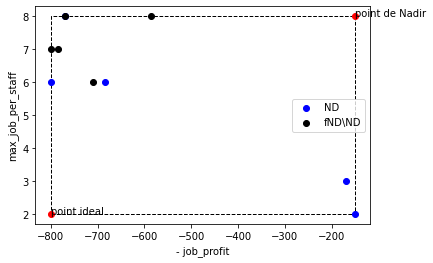

In [51]:
fig, ax = plt.subplots(1, 1)
ax.add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                           facecolor='none',
                          edgecolor='black',
                           ls='--'))
ax.scatter(list(x_ND),list(y_ND),c='blue',label='ND')
ax.scatter(list(x_rest),list(y_rest),c='black',label=r'fND\ND')


ax.scatter(x_min,y_min,c='r')
ax.scatter(x_max,y_max,c='r')

ax.text(x_min, y_min, 'point ideal')
ax.text(x_max, y_max, 'point de Nadir')
ax.set_xlabel('- job_profit')
ax.set_ylabel('max_job_per_staff')
ax.legend()

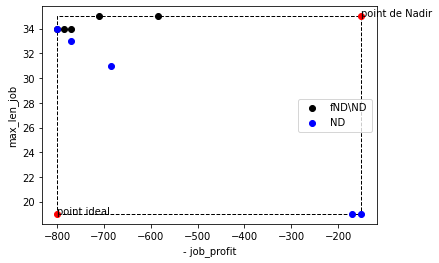

In [16]:
fig, ax = plt.subplots(1, 1)
ax.add_patch(plt.Rectangle((x_min, z_min), x_max-x_min, z_max-z_min,
                           facecolor='none',
                          edgecolor='black',
                           ls='--'))
ax.scatter(list(x_rest),list(z_rest),c='black',label=r'fND\ND')

ax.scatter(list(x_ND),list(z_ND),c='blue',label='ND')


ax.scatter(x_min,z_min,c='r')
ax.scatter(x_max,z_max,c='r')

ax.text(x_min, z_min, 'point ideal')
ax.text(x_max, z_max, 'point de Nadir')
ax.set_xlabel('- job_profit')
ax.set_ylabel('max_len_job')
ax.legend()

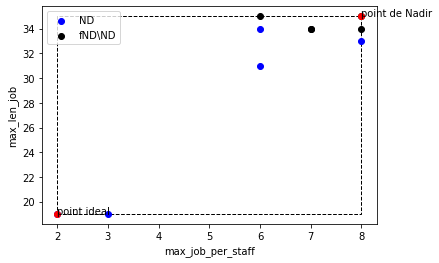

In [53]:
fig, ax = plt.subplots(1, 1)
ax.add_patch(plt.Rectangle((y_min, z_min), y_max-y_min, z_max-z_min,
                           facecolor='none',
                          edgecolor='black',
                           ls='--'))
ax.scatter(list(y_ND),list(z_ND),c='blue',label='ND')
ax.scatter(list(y_rest),list(z_rest),c='black',label=r'fND\ND')


ax.scatter(y_min,z_min,c='r')
ax.scatter(y_max,z_max,c='r')

ax.text(y_min, z_min, 'point ideal')
ax.text(y_max, z_max, 'point de Nadir')
ax.set_xlabel('max_job_per_staff')
ax.set_ylabel('max_len_job')
ax.legend()

## Determining best solution

In [54]:
solutions[list(set_ND)]

array([[-800,    6,   34],
       [-770,    8,   33],
       [-685,    6,   31],
       [-170,    3,   19],
       [-150,    2,   19]])

### Scenario 1: weight and lambda values are known

In [38]:
# Creating outranking matrix for ND solutions

def create_outrank_matrix(weights,lambda_value,solutions):
    
    # Retrieving ND solutions from solution space
    x,y,z = solutions[:,0],solutions[:,1],solutions[:,2]
    set_ND,set_rest = ND(solutions)
    x_ND,y_ND,z_ND = [x[i] for i in set_ND],[y[i] for i in set_ND],[z[i] for i in set_ND]
    
    # Initializing score matrix
    score_matrix = np.zeros(shape=(len(set_ND),len(set_ND)))

    for i in range(len(set_ND)):
        for j in range(len(set_ND)):
            if i==j:
                score_matrix[i][j] = 1
            else:
                weight_sum = (x_ND[i]<=x_ND[j])*weights[0]+(y_ND[i]<=y_ND[j])*weights[1]+(z_ND[i]<=z_ND[j])*weights[2]
                score_matrix[i][j] = weight_sum
    
    # Initializing outranking matrix
    outrank_matrix = score_matrix>=lambda_value
    
    return score_matrix, outrank_matrix



In [39]:
create_outrank_matrix(weights=[0.6,0.3,0.1],lambda_value=0.6,solutions=solutions)

(array([[1. , 0.9, 0.9, 0.6, 0.6],
        [0.1, 1. , 0.6, 0.6, 0.6],
        [0.4, 0.4, 1. , 0.6, 0.6],
        [0.4, 0.4, 0.4, 1. , 0.7],
        [0.4, 0.4, 0.4, 0.4, 1. ]]),
 array([[ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]]))

Best solution is therefore solution A: 
- profit: 800
- Mean number of jobs done by staff: 6
- Maximum period of a single project: 35 days (34+1)

### Scenario 2: only pairwise preferences are known

In [33]:
solutions[list(set_ND)]

array([[-800,    6,   34],
       [-770,    8,   33],
       [-685,    6,   31],
       [-170,    3,   19],
       [-150,    2,   19]])

- 1P2: (w1+w2 >= L) & (w3 < L)
- 1P5: (w1 >= L) & (w2+w3 < L)
- 1P3: (w1+w2 >= L) & (w2 + w3 <L)
- 4P5: (w1+w3 >= L) & (w2 + w3 <L)

In [23]:
epsilon = 1e-3


m = Model("Solving linear program")

# Création de 2 variables continues v0 et v1
w1 = m.addVar(lb=0.1)
w2 = m.addVar(lb=0.1)
w3 = m.addVar(lb=0.1)
L = m.addVar(lb=0.5,ub=1.0)
# maj du modèle
m.update()
# Ajout de 3 constraintes 
m.addConstr(w1 + w2 + w3 == 1)
m.addConstr(w1 + w2 >= L)
m.addConstr(w3 <= L - epsilon)
m.addConstr(w2 + w3 <= L - epsilon)
m.addConstr(w1 + w3 >= L)
# Fonction Objectif
m.setObjective(L, GRB.MINIMIZE)         
# Paramétrage (mode mute)
m.params.outputflag = 0
# Résolution du PL
m.optimize()
print("Optimal solution has weights (w1, w2, w3) = {} and lambda value L = {}".format((w1.x, w2.x, w3.x), L.x))

Optimal solution has weights (w1, w2, w3) = (0.8, 0.1, 0.1) and lambda value L = 0.5


In [24]:
create_outrank_matrix(weights=[0.8,0.1,0.1],lambda_value=0.5,solutions=solutions)

(array([[1. , 0.9, 0.9, 0.8, 0.8],
        [0.1, 1. , 0.8, 0.8, 0.8],
        [0.2, 0.2, 1. , 0.8, 0.8],
        [0.2, 0.2, 0.2, 1. , 0.9],
        [0.2, 0.2, 0.2, 0.2, 1. ]]),
 array([[ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]]))

In [26]:
epsilon = 1e-3


m = Model("Solving linear program")

# Création de 2 variables continues v0 et v1
w1 = m.addVar(lb=0.1)
w2 = m.addVar(lb=0.1)
w3 = m.addVar(lb=0.1)
L = m.addVar(lb=0.5,ub=1.0)
# maj du modèle
m.update()
# Ajout de 3 constraintes 
m.addConstr(w1 + w2 + w3 == 1)
m.addConstr(w1 + w2 >= L)
m.addConstr(w3 <= L - epsilon)
m.addConstr(w2 + w3 <= L - epsilon)
m.addConstr(w1 + w3 >= L)
# Fonction Objectif
m.setObjective(L, GRB.MAXIMIZE)         
# Paramétrage (mode mute)
m.params.outputflag = 0
# Résolution du PL
m.optimize()
print("Optimal solution has weights (w1, w2, w3) = {} and lambda value L = {}".format((w1.x, w2.x, w3.x), L.x))

Optimal solution has weights (w1, w2, w3) = (0.8, 0.1, 0.1) and lambda value L = 0.9


In [31]:
create_outrank_matrix(weights=[0.8, 0.1, 0.1],lambda_value=0.8,solutions=solutions)

(array([[1. , 0.9, 0.9, 0.8, 0.8],
        [0.1, 1. , 0.8, 0.8, 0.8],
        [0.2, 0.2, 1. , 0.8, 0.8],
        [0.2, 0.2, 0.2, 1. , 0.9],
        [0.2, 0.2, 0.2, 0.2, 1. ]]),
 array([[ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]]))